* 6 models
    * 2 FC
    * 2 2D CNN
    * 2 3D CNN
    * Shouldn't overfit ( < 600k parameters )
* Visualize CNN kernels
    * Identify frequnecy bands that are being observed

In [26]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from tqdm import tqdm

%matplotlib inline

## Load data

In [4]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
# IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
# IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

# X = np.concatenate((TDC, IDD))

X_scalogram = np.load("Data/GeneratedData/X_scalogram_music.npy")
Y = [0]*(len(X_scalogram)//2) + [1]*(len(X_scalogram)//2)
Y = np.asarray(Y)

In [6]:
print(X_scalogram.shape)
print(Y.shape)

(8470, 448, 128)
(8470,)


## Create Spectrograms

In [7]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''
    
    downsample = int(round(Hz / hz))
    X = x[0: num_secs * Hz : downsample]


    t, dt = np.linspace(0, num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm

In [8]:
def generate_scalogram(data, Hz, hz, num_secs, w = 5.):
    scalogram_data = np.zeros((data.shape[0], data.shape[1] * (hz // 2), hz * num_secs), dtype="complex128")
    for sample_index in tqdm(range(data.shape[0])):
        for channel_index in range(0, data.shape[1]):
            scalogram_data[sample_index][channel_index * (hz//2): channel_index * (hz//2) + hz//2] = \
            scalogram(data[sample_index][channel_index], 128, 64, 2)
    return scalogram_data

In [103]:
# X_scalogram = generate_scalogram(X, 128, 64, 2)


100%|██████████| 8470/8470 [04:28<00:00, 31.56it/s]


In [9]:
X_scalogram.shape

(8470, 448, 128)

In [10]:
def plot_scalograms(data, labels, sample_index, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, (14 * (fs / 2)), (14 * int(hz / 2)))
    
    print("Y label:", labels[sample_index])
    
    plt.rcParams['figure.figsize'] = 14, 30
    im = plt.pcolormesh(t, freq, np.abs(data[sample_index]), cmap = 'jet') # 'viridis'
    plt.show()


Y label: 1


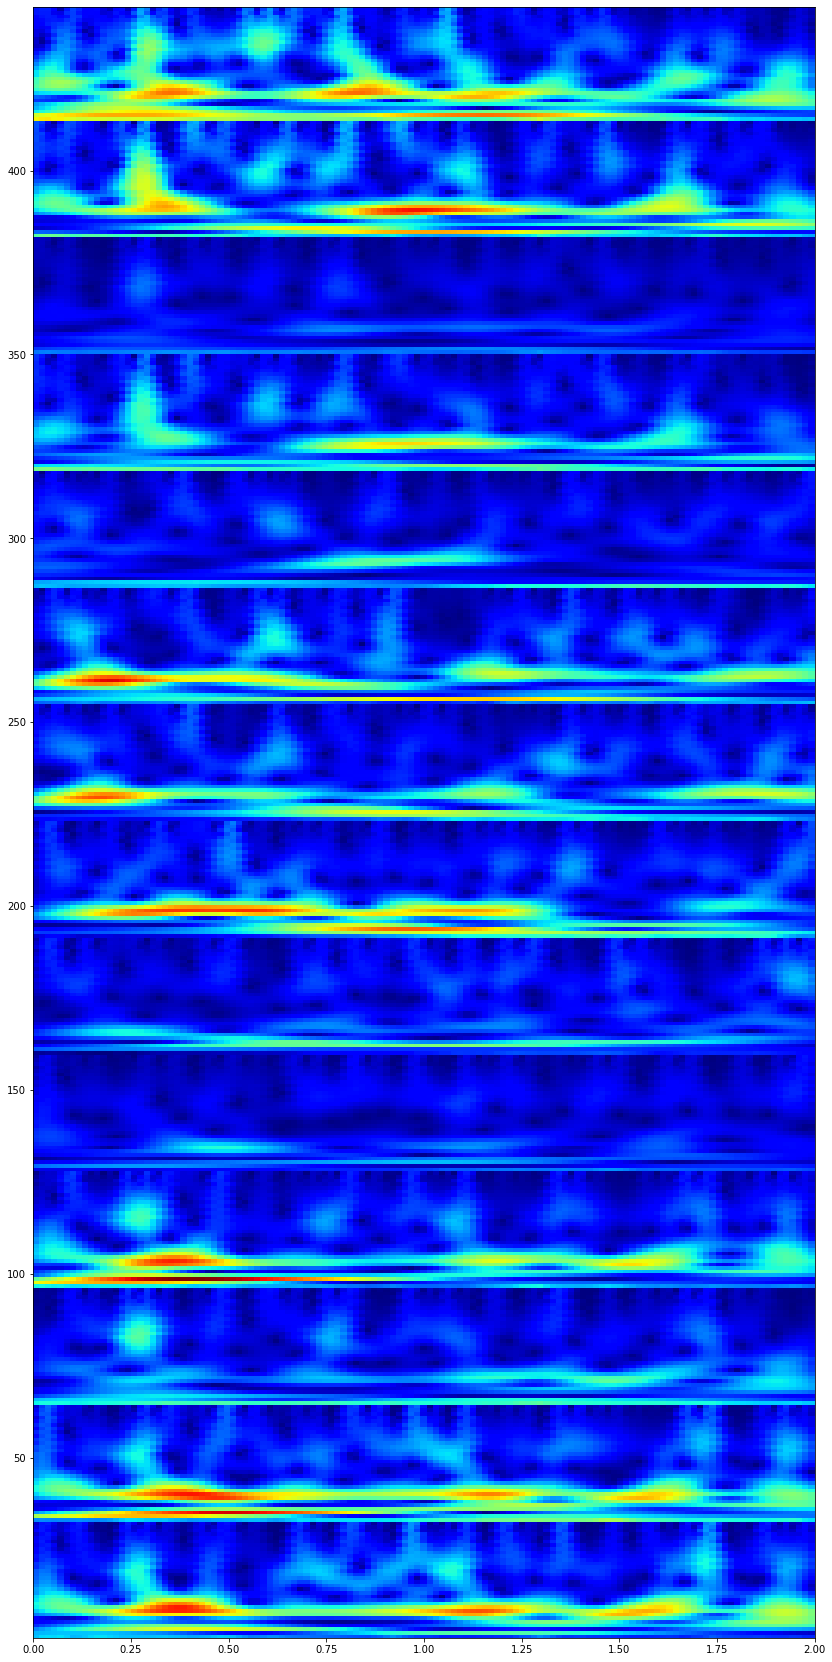

In [11]:
plot_scalograms(X_scalogram, Y, 5000)

In [12]:
# reshape data
X_scalogram_shaped = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1], X_scalogram.shape[2], 1)
X_scalogram_shaped.shape

(8470, 448, 128, 1)

## Test-Train split

In [108]:
# X_train, X_val, y_train, y_val = train_test_split(X_scalogram_shaped, Y, test_size=0.2, stratify=Y, random_state=42)

In [33]:
# 12/2 split
X_train = np.concatenate((X_scalogram_shaped[:3630], X_scalogram_shaped[4235:7865]))
y_train = np.concatenate((Y[:3630], Y[4235:7865]))

X_val = np.concatenate((X_scalogram_shaped[3630:4235], X_scalogram_shaped[7865:]))
y_val = np.concatenate((Y[3630:4235], Y[7865:]))


# 10/4 split
# X_train = np.concatenate((X_scalogram_shaped[:3025], X_scalogram_shaped[4235:7260]))
# y_train = np.concatenate((Y[:3025], Y[4235:7260]))

# X_val = np.concatenate((X_scalogram_shaped[3025:4235], X_scalogram_shaped[7260:]))
# y_val = np.concatenate((Y[3025:4235], Y[7260:]))

# shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_val, y_val = shuffle(X_val, y_val, random_state=42)

In [34]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
input_shape = X_train.shape[1:]
print("input shape:", input_shape)

X_train shape: (7260, 448, 128, 1)
y_train shape: (7260,)
X_val shape: (1210, 448, 128, 1)
y_val shape: (1210,)
input shape: (448, 128, 1)


In [109]:
# print("X_train shape:", X_train.shape)
# print("y_train shape:", y_train.shape)
# print("X_val shape:", X_val.shape)
# print("y_val shape:", y_val.shape)
# input_shape = X_train.shape[1:]

X_train shape: (6776, 448, 128, 1)
y_train shape: (6776,)
X_val shape: (1694, 448, 128, 1)
y_val shape: (1694,)


## Model

In [17]:
def plot_history(history):
    # Retrieve a list of accuracy results on training and test data
    # sets for each training epoch
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Retrieve a list of list results on training and test data
    # sets for each training epoch
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))
    plt.figure(figsize=(6.4,4.8))
    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train', 'val'], loc='upper left')

    plt.figure(figsize=(6.4,4.8))

    # Plot training and validation loss per epoch
    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train', 'val'], loc='upper left')

In [111]:
# base_model = keras.Sequential([
#     # Set input layer
#     keras.layers.InputLayer(input_shape=input_shape),
    
#     # Conv + Maxpooling
#     keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
#     # Normalization
#     keras.layers.BatchNormalization(),
    
#     # Flatten and convert from 3D to 1D
#     keras.layers.Flatten(),
    
#     # Sigmoid
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# base_model.compile(
#   optimizer='adam',
#   loss='binary_crossentropy',
#   metrics=['accuracy'],
# )
# base_model.summary()


In [112]:
# plot_history(base_model.fit(X_train, 
#                     y_train, 
#                     epochs=10, 
#                     batch_size=128,
#                     validation_data=(X_val, y_val), 
#                     verbose=1))

In [35]:
# REST MODEL
complex_model = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
    keras.layers.Dense(16, activation=tf.nn.relu),
    
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(8, activation=tf.nn.relu),
    
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [119]:
# MUSIC MODEL
# complex_model = keras.Sequential([
#     # Set input layer
#     keras.layers.InputLayer(input_shape=input_shape),
    
#     # Conv + Maxpooling
#     keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
#     keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
#     keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
#     # Normalization
#     keras.layers.BatchNormalization(),
    
#     # Flatten and convert from 3D to 1D
#     keras.layers.Flatten(),
    
#     keras.layers.Dense(20, activation=tf.nn.relu),
    
#     keras.layers.Dropout(0.5),
    
#     keras.layers.Dense(10, activation=tf.nn.relu),
    
    
#     # Sigmoid
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])


In [36]:
complex_model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)
complex_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 448, 128, 8)       80        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 224, 64, 8)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 224, 64, 8)        584       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 32, 8)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 112, 32, 8)        32        
_________________________________________________________________
flatten_3 (Flatten)          (None, 28672)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)               

Train on 7260 samples, validate on 1210 samples
Epoch 1/5
7260/7260 [==============================] - 88s 12ms/sample - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.7567 - val_accuracy: 0.8521
Epoch 2/5
7260/7260 [==============================] - 90s 12ms/sample - loss: 0.0287 - accuracy: 0.9898 - val_loss: 0.7167 - val_accuracy: 0.8322
Epoch 3/5
7260/7260 [==============================] - 91s 13ms/sample - loss: 0.0302 - accuracy: 0.9905 - val_loss: 0.7306 - val_accuracy: 0.8421
Epoch 4/5
7260/7260 [==============================] - 89s 12ms/sample - loss: 0.0330 - accuracy: 0.9887 - val_loss: 0.6751 - val_accuracy: 0.8818
Epoch 5/5
7260/7260 [==============================] - 89s 12ms/sample - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.6423 - val_accuracy: 0.8579


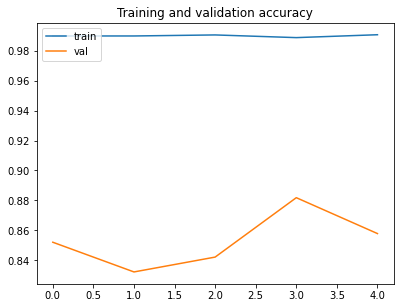

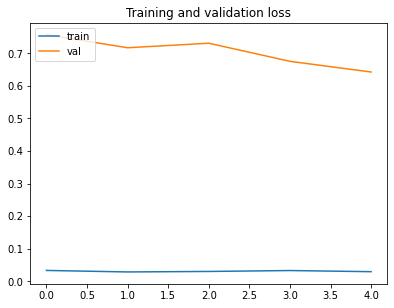

In [40]:
plot_history(complex_model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1))

* 12/2
    * Rest
        * 81.2%
        * 86.4% (shuffled, 15 epochs)
        * 91.4% (shuffled, 25 epochs)
* 10/4
    * Rest 
        * 83.1%
        * 93.2% (Shuffled, 15 epochs)


---

* Base Model
    * Music
        * Validation accuracy: 99.47%
        * Validation loss: 0.0161
    * Rest
        * Validation accuracy: 99.53%
        * Validation loss: 0.0140
        
* Complex Model
    * Music
        * Validation accuracy: 99.94%
        * Validation loss: 0.0019
    * Rest
        * Validation accuracy: 99%?
        * Validation loss: ?


## Visualize Layers

In [122]:
from tensorflow.keras.models import Model
layer_outputs = [layer.output for layer in complex_model.layers]
for layer in layer_outputs:
    print(layer)
# feature_map_model = Model(inputs=complex_model.input, output=layer_outputs)
feature_map_model = Model(complex_model.input, layer_outputs)

Tensor("conv2d_6/Identity:0", shape=(None, 448, 128, 8), dtype=float32)
Tensor("max_pooling2d_6/Identity:0", shape=(None, 224, 64, 8), dtype=float32)
Tensor("conv2d_7/Identity:0", shape=(None, 224, 64, 8), dtype=float32)
Tensor("max_pooling2d_7/Identity:0", shape=(None, 112, 32, 8), dtype=float32)
Tensor("batch_normalization_3/Identity:0", shape=(None, 112, 32, 8), dtype=float32)
Tensor("flatten_3/Identity:0", shape=(None, 28672), dtype=float32)
Tensor("dense_9/Identity:0", shape=(None, 20), dtype=float32)
Tensor("dropout_3/Identity:0", shape=(None, 20), dtype=float32)
Tensor("dense_10/Identity:0", shape=(None, 10), dtype=float32)
Tensor("dense_11/Identity:0", shape=(None, 1), dtype=float32)


In [123]:
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*10,col_size*8))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='jet')
            activation_index += 1
            ax[row][col].set(yticklabels=[])

Indices used
* Rest
    * TDC: 3500
    * IDD: 200
* Music
    * TDC: 2800
    * IDD: 2800


Y label: 0


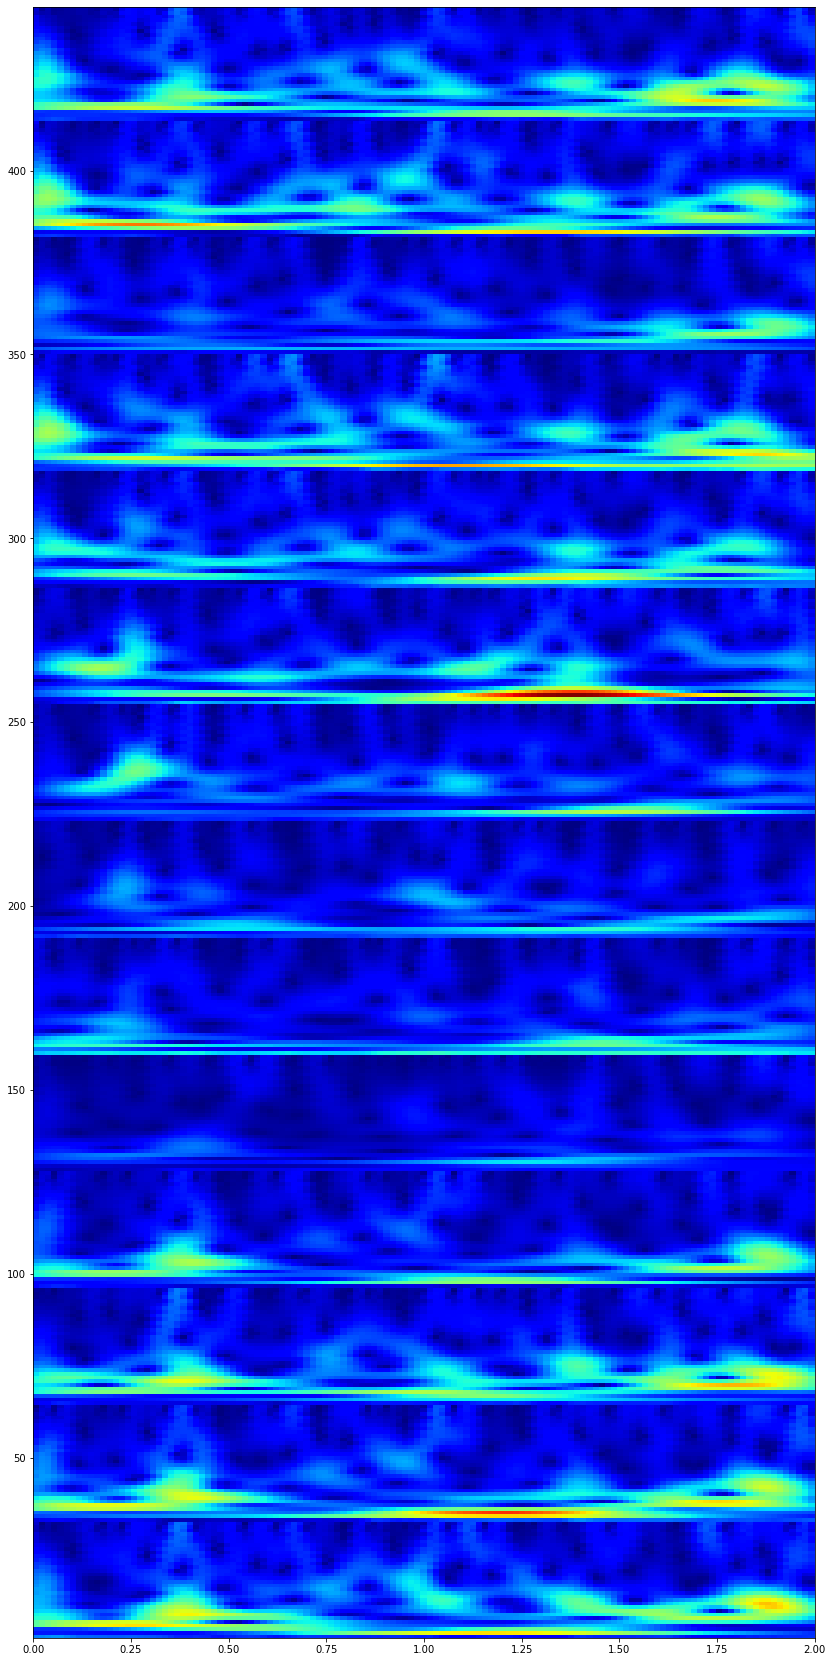

In [131]:
index = 1800
plot_scalograms(X_train.reshape(6776, 448, 128), y_train, index)

Label:  0
Prediction:  7.4338706e-05


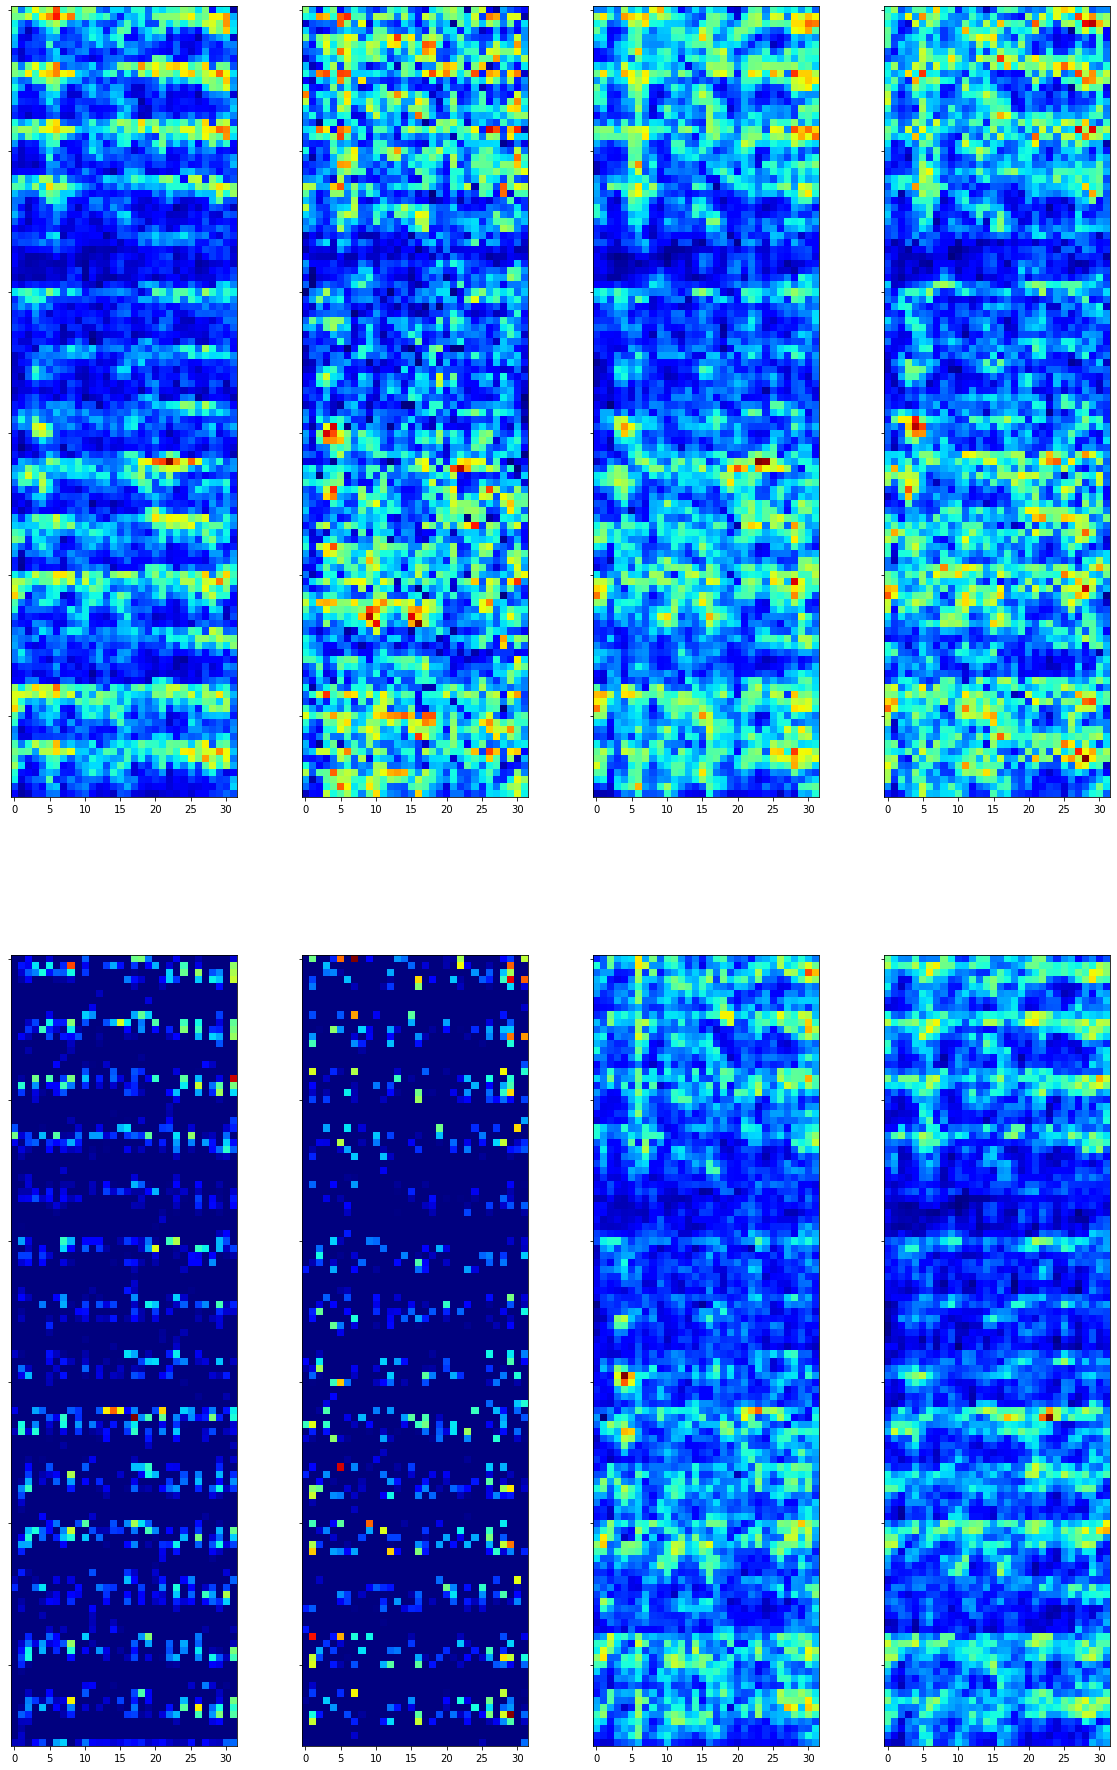

In [136]:
activations = feature_map_model.predict(X_train[index].reshape(1,448,128,1))
display_activation(activations, 4, 2, 3)

print("Label: ", y_train[index])
print("Prediction: ", activations[9][0][0])

Y label: 1


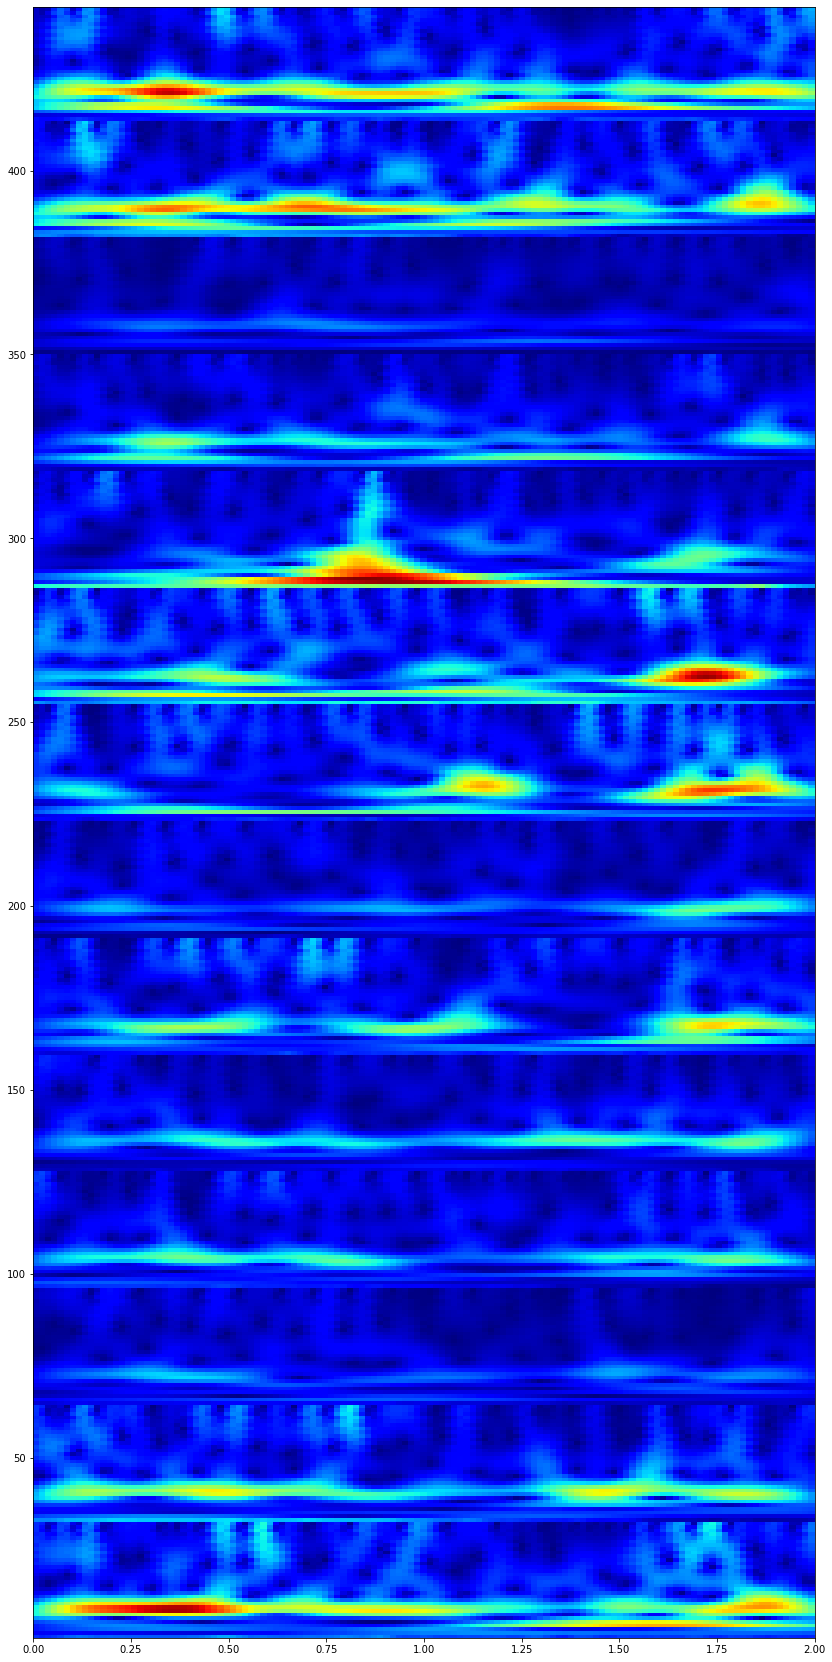

In [142]:
index = 2800
plot_scalograms(X_train.reshape(6776, 448, 128), y_train, index)

Label:  1
Prediction:  1.0


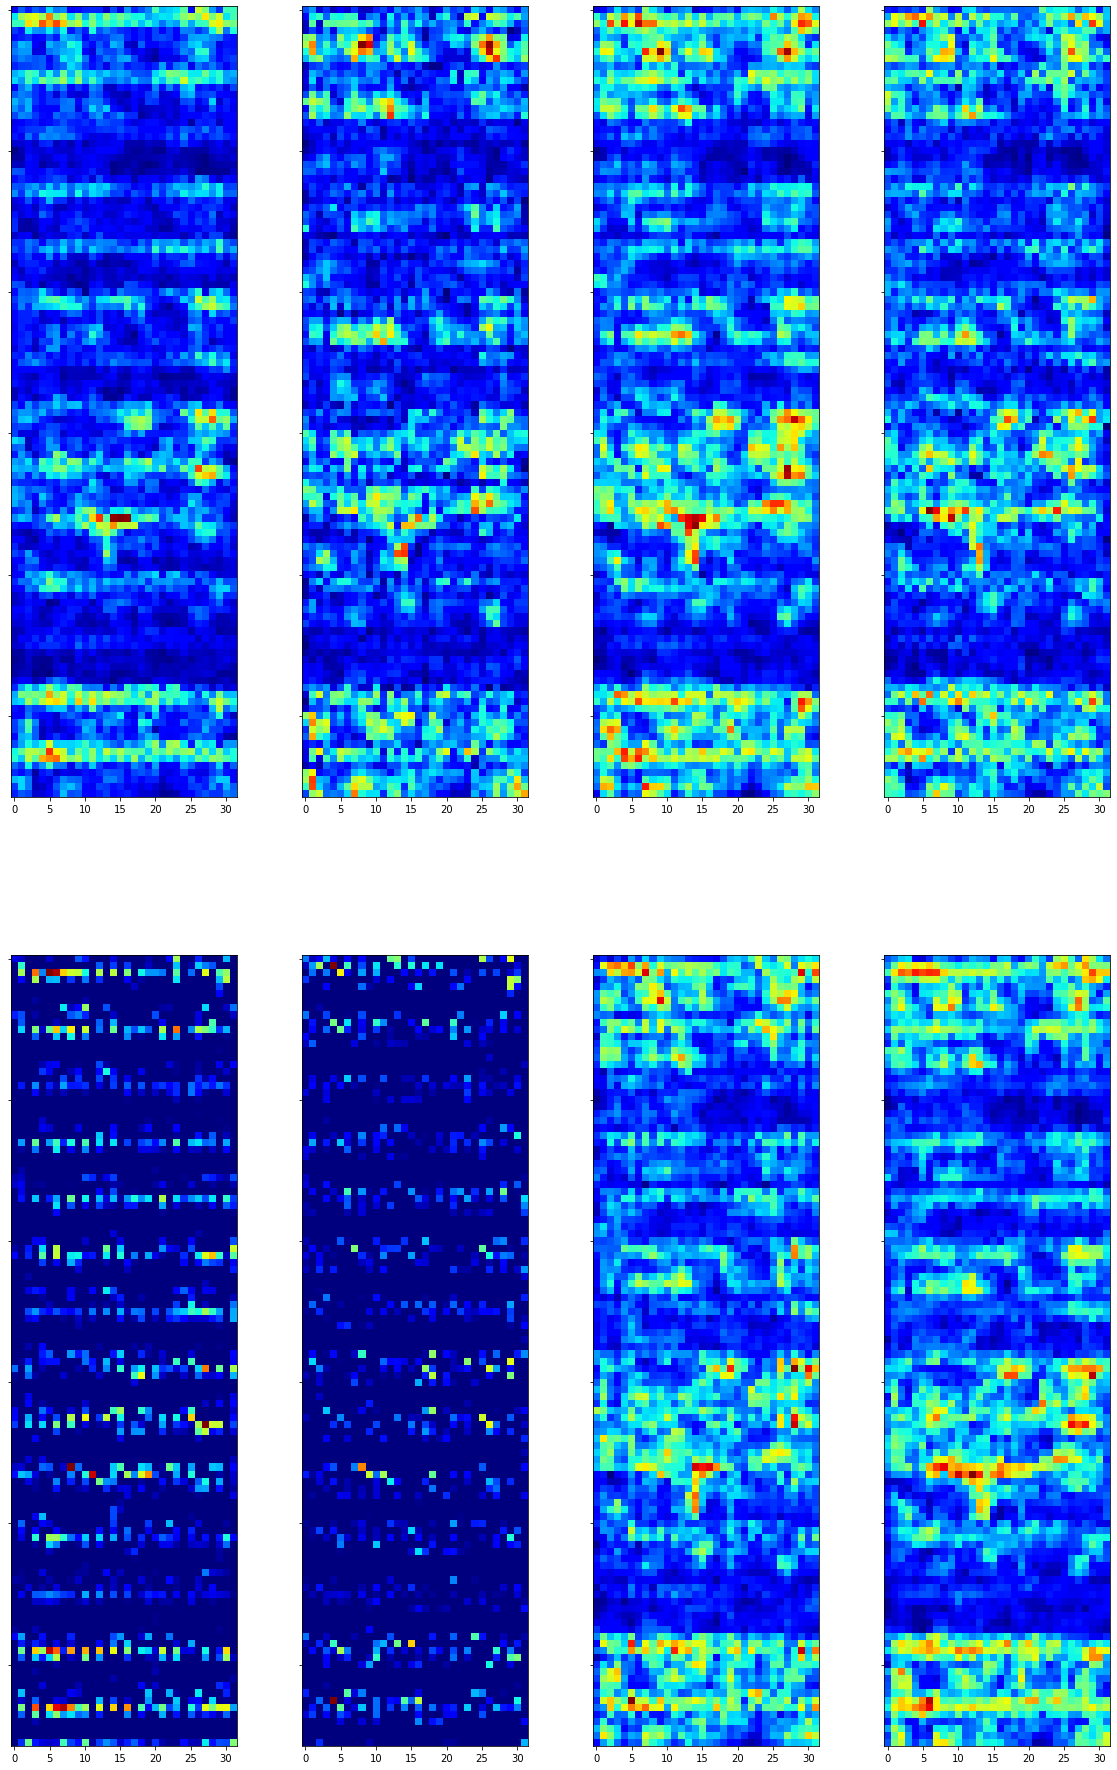

In [147]:
activations = feature_map_model.predict(X_train[index].reshape(1,448,128,1))
display_activation(activations, 4, 2, 3)
print("Label: ", y_train[index])
print("Prediction: ", activations[9][0][0])